# Stokes drifters
In this notebook we check settings for "stokes drifters like" macroplastics. We for now assume: 
1. spherical particles with diameter disk stokes-drifter and buoyancy stokes drifter
2. no wind drag

We look into following things
1. Timescales particles
2. tidal signal
3. testing code for small displacement initial position particles (for simulation to check dispersion effect of field itself)



In [21]:
# reload updated packages
%load_ext autoreload
%autoreload 2


# import needed packages
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import numpy as np
from scipy.optimize import fsolve
plt.style.use('../python_style_Meike.mplstyle')

#import functions
from particle_characteristics_functions import buoyancy_drifter, stokes_relaxation_time
from particle_characteristics_functions import Re_particle, diffusion_time
from particle_characteristics_functions import factor_drag_white1991, factor_drag_Schiller1933, factor_drag_morrison2013
from particle_characteristics_functions import drag_length
from particle_characteristics_functions import find_rep_morrison2013, find_rep_schiller1933, find_rep_white1991




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Calculating buoyancy and stokes relaxation time for stokes type drifters
# 
d = 0.25 # m diameter outer ring
d_in = 0.2 # m (estimated) dimater inner ring, needed to caluclate volume
h = 0.041  # m (heigth drifter)
m = 0.905 # kg (mass drifter)
cd=0.45 # drag coefficient smooth sphere 
rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water
B = buoyancy_drifter(diameter  = d_in, heigth = h, mass = m, density_fluid = rho_water)
tau = stokes_relaxation_time(d, kinematic_viscosity_water, B)
tau_diff = diffusion_time(d_in, kinematic_viscosity_water)
print(f'B = {B:.2f}')
print(f'tau = {tau:.2f} s')

print(f'tau_diff = {tau_diff:.2f} s')
ld = drag_length(d_in,B,cd)
print(f'ld = {ld} m')


B = 0.68
tau = 2994.76 s
tau_diff = 29134.75 s
ld = 0.7017120538540955 m


2387.567386113758
7104.676659622208


Text(0, 0.5, 'time [s]')

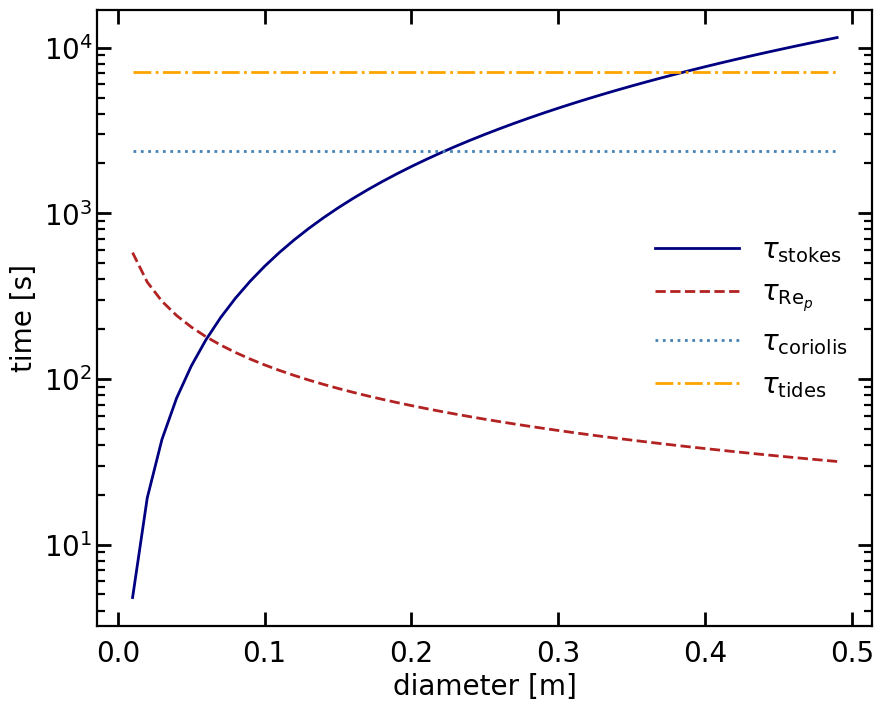

In [26]:
# comparing timescales as function of particle diameter

# particle diameter range between 1 cm and 50 cm
dlist= np.arange(0.01,0.5,0.01) #in m

# stokes relaxation time as function of diameter
tau_stokes = stokes_relaxation_time(diameter = dlist, kinematic_viscosity=kinematic_viscosity_water,buoyancy=B)

# coriolis time scale
tau_coriolis = 1/(2 * (7.2921159 * 10**-5) * np.sin(50*np.pi/180)) * (2*(1-B))/(1+2*B)
print(tau_coriolis)
#tides timescale
tau_tides =  12.4 * 3600 / (2*np.pi)
print(tau_tides)

# Rep>1 drag correction factor, 
Crep = factor_drag_white1991(Re_particle(Uslip = 0.01,diameter = dlist,kinematic_viscosity = kinematic_viscosity_water))

# drag relaxation time (for non stokes drag (i.e. Rep > 1) given by tau_Rep  = tau_stokes/Crep)
tau_rep = tau_coriolis / Crep

#compare different timescales
fig, ax = plt.subplots()
ax.plot(dlist,tau_stokes,color='navy')
ax.plot(dlist,tau_rep,'--',color='firebrick')
ax.plot(dlist,np.full(dlist.size,tau_coriolis),':',color='steelblue')
ax.plot(dlist,np.full(dlist.size,tau_tides),'-.',color='orange')

ax.legend(['$\\tau_{\\mathrm{stokes}}$','$\\tau_{\\mathrm{Re}_p}$','$\\tau_{\\mathrm{coriolis}}$','$\\tau_{\\mathrm{tides}}$'])

ax.set_yscale('log')
ax.set_xlabel('diameter [m]')
ax.set_ylabel('time [s]')



In [ ]:
clist =[]
for d in dlist:
    
    sol1 = fsolve(find_rep_white1991,0.1*1000*d,(tau_coriolis,tau_tides,B,kinematic_viscosity_water,d))
 
    sol2 = fsolve(find_rep_morrison2013,0.1*d,(tau_coriolis,tau_tides,B,kinematic_viscosity_water,d))


    clist.append(factor_drag_morrison2013(sol2[0]))

print(clist)

[2.2547501358996875, 4.27089909310328, 6.631642854772238, 9.32268266884083, 12.313263400814572, 15.579122725985988, 19.101228313988226, 22.864228425776922, 26.855416304375762, 31.064050371710806, 35.48089404505005, 40.09789319952452, 44.907942886724854, 49.9047139622706, 55.08252119835016, 60.43622092093998, 65.96113016837243, 71.65296186922127, 77.5077721657571, 83.52191709711035, 89.69201660068481, 96.01492431034862, 102.48770200020662, 109.10759779092652, 115.87202743285657, 122.77855812724475, 129.82489445821716, 137.0088660929391, 144.32841697327805, 151.78159577346005, 159.3665474386419, 167.08150565141975, 174.9247860990085, 182.8947804345726, 190.98995084305167, 199.2088251356127, 207.54999230820636, 216.01209850910016, 224.5938433680727, 233.29397664649258, 242.11129517299855, 251.04464003413548, 260.09289399323615, 269.2549791141875, 278.5298545695721, 287.9165146152135, 297.4139867150088, 307.0213298022416, 316.73763266461066]


In [ ]:
#drag_relaxation time = tstokes /C(Rep) as function of t:
dlist= np.arange(0.01,1,0.01) #in m
tau_stokes = stokes_relaxation_time(diameter= dlist, kinematic_viscosity=kinematic_viscosity_water,B=B)
Crep = factor_drag_white1991(Re_particle(0.0001,dlist,kinematic_viscosity_water))
fcor =(2 * (7.2921159 * 10**-5) * np.sin(50*np.pi/180))
fig, ax = plt.subplots()
ax.plot(dlist,tau_stokes*fcor * 2*(1-B)/(1 + 2 * B),color='navy')
ax.plot(dlist,tau_stokes/Crep*fcor * 2*(1-B)/(1 + 2 * B),color='navy')
# ax.plot(dlist,tau_stokes/10,color='firebrick')
# ax2=ax.twinx()
# ax2.plot(dlist,Crep)
# ax.axhline(tcoriolis,color='grey',zorder=-5)


TypeError: stokes_relaxation_time() got an unexpected keyword argument 'viscosity_water'

In [55]:
d=0.25
d*d*1.2*10**(4)/2387.567386113758

0.31412725955382337

In [75]:
5/300

0.016666666666666666

In [49]:
 1.2*10**(2)/7104.676659622208 + 1.2*10**(2)/2387.567386113758

0.06715064461242783

In [ ]:
rho_PE = 961 # kg / m^3
tau_PE = stokes_relaxation_time(1/10, kinematic_viscosity_water, rho_PE / rho_water)
print(tau_PE)

580.9692671394798


In [38]:
stokes_relaxation_time(1, kinematic_viscosity_water, B) * 2 * ( 1- B) / (1 + 2*  B)

12781.290530633822

Text(0.5, 0, '$\\mathrm{Re}_p$')

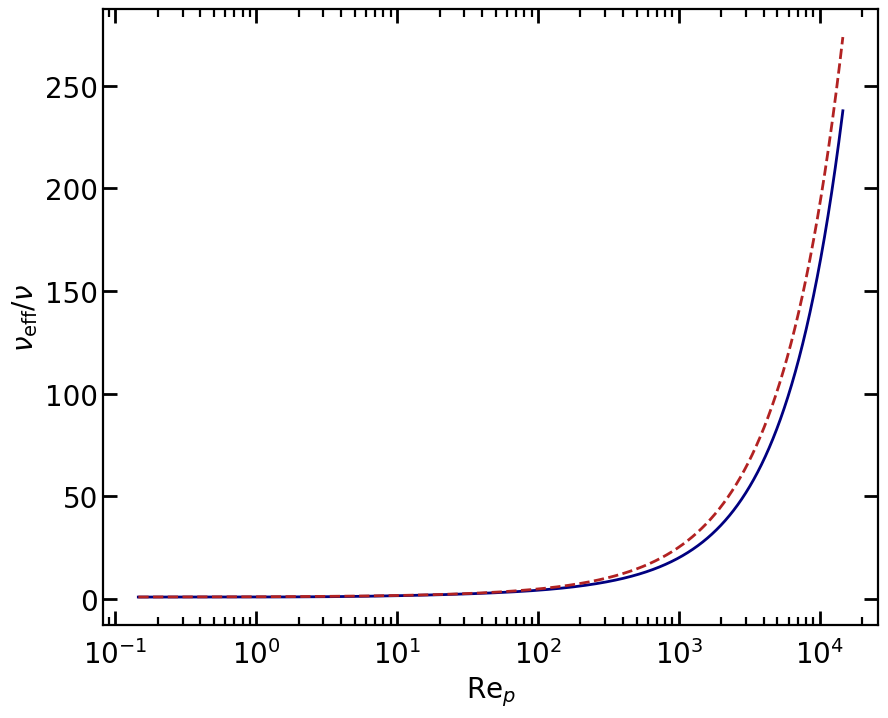

In [7]:
# check drag factor ( and force)
Uslip=np.arange(0.000001,0.1,0.000001)
REp = Re_particle(Uslip,d_in,kinematic_viscosity_water)
f_drag = factor_drag(Uslip,d_in,kinematic_viscosity_water,B)
fdrag2 = factor_drag_2(Uslip,d_in,kinematic_viscosity_water)
fig,ax = plt.subplots()
ax.plot(REp,f_drag,color='navy')
ax.plot(REp,fdrag2,'--',color='firebrick')
ax.set_xscale('log')
ax.set_ylabel('$\\nu_{\\mathrm{eff}}/\\nu$')
ax.set_xlabel('$\\mathrm{Re}_p$')
# ax.plot(REp[0:], (24/REp  + 
#               2.6 * (REp / 5.) / (1 + (REp/5.)**(1.52))  +
#               0.25 * (REp) / ((10**6) + REp  )
#             ) )

# ax.plot(REp[0:], (24/REp)   )
# ax.set_yscale('log')

# calculate drag force as function of slip velocity
Calvert,...,Bremer claim that non-viscous drag force is significantly smaller than its viscous equivalent and I do not see this happening?
So I will test it for particle of 10cm with viscosity water of 10^-6 resulting in Rep = uslip 10^5 
we use the newtoninan formulation of the drag force and the morrison2023 formulation of the drag coefficient

In [4]:
def CD_morrison2013(Rep):
    """
    Emperical stokes drag correction factor valid up to Rep < 10^6 from
    [1] F. A. Morrison, An introduction to fluid mechanics (2013)
    """
    c_REp = (24/Rep + 
             2.6 * (Rep / 5.) / (1 + (Rep/5.)**(1.52))  +
             0.411 * (Rep / (2.63 * 10**5))**(-7.94) / (1 + (Rep / (2.63 * 10**5))**(-8)) +
             0.25 * (Rep) / ((10**6) + Rep  )
            )
    #tau_inv = 36 * nu * f_REp /( (1. + 2. * B) * L**2)
    return c_REp#tau_inv

def Rep(U,nu,d):
    return U * d / nu

def F_drag(U, Cd, rho_f, d):
    A = np.pi * d * d / 4
    return 0.5 * Cd * rho_f * A * U * U

def F_stokes(U,rho_f,nu,d):
    return 3 * np.pi * rho_f * nu * d * U

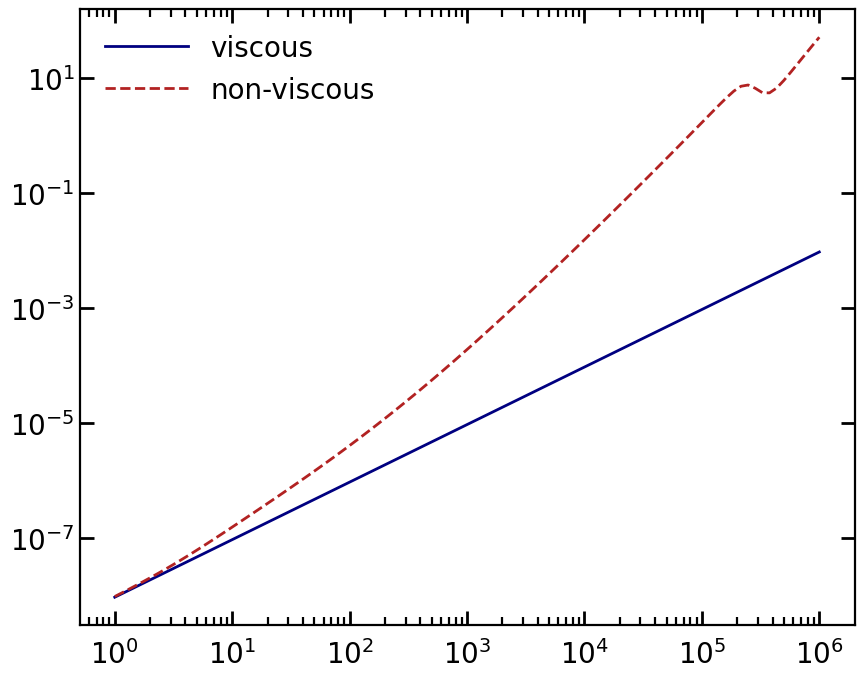

In [10]:
nu = 10**(-6)
rho = 10**3
d = 0.1
U=np.logspace(-5,1,100)

rep = Rep(U, nu, d)
cd = CD_morrison2013(rep)
fdrag = F_drag(U,cd,rho,d)
fstokes = F_stokes(U,rho,nu,d)

fig,ax=plt.subplots()
ax.plot(rep,fstokes,'-',color='navy')
ax.plot(rep,fdrag,'--',color='firebrick')
ax.legend(['viscous','non-viscous'])
ax.set_xscale('log')
ax.set_yscale('log')

# Test displacacment code

In [4]:
# test displacement code

def displace_coordinates(lon, lat, d, B):
    """
    Function that displaces point(s) given by lon, lat over a distance d
    (in meters) in direction B (angle measured clockwise in radians from the
    north pole). The function returns the lon and lat coordinates of the
    displaced point(s).
    """
    Rearth = 6371 * 10**3 # radius earth in m
    lon_rad = lon * np.pi/180. 
    lat_rad = lat * np.pi/180. 
    lat_new = np.arcsin(np.sin(lat_rad) * np.cos(d / Rearth)+np.cos(lat_rad) * np.sin( d/ Rearth) * np.cos(B))
    lon_new = lon_rad + np.arcsin( np.sin(d / Rearth) * np.sin(B) / np.cos(lat_new))
    lat_new_angle = lat_new * 180/np.pi 
    lon_new_angle = lon_new * 180/np.pi 
    return lon_new_angle, lat_new_angle




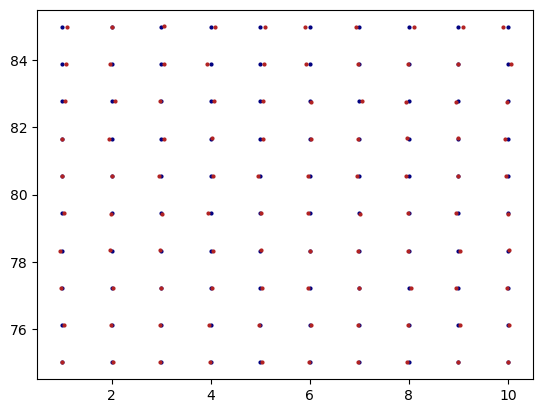

In [7]:
lon = np.linspace(1,10,10)
lat = np.linspace(75,85,10)
lon_particles, lat_particles = np.meshgrid(lon,lat)
lon_particles = lon_particles.flatten()
lat_particles = lat_particles.flatten()
nparticles=lat_particles.size
d = 1000 # displacement in meters
theta = np.random.rand(nparticles)*2*np.pi

lon_d, lat_d = displace_coordinates(lon_particles,lat_particles,d,theta)

fig,ax = plt.subplots()
ax.plot(lon_particles,lat_particles, 'o',color='navy',markersize=2)
ax.plot(lon_d,lat_d, 'o',color='firebrick',markersize=2)

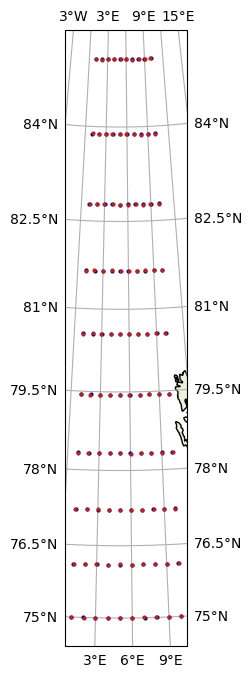

In [16]:

proj = ccrs.LambertConformal(central_longitude=5, central_latitude=80)

fig, ax = plt.subplots(facecolor="w", figsize=(20,8),
    subplot_kw=dict(projection=proj),
)

    
ax.plot(lon_particles,lat_particles, 'o',color='navy',markersize=2,zorder=20, transform=ccrs.PlateCarree())
ax.plot(lon_d,lat_d, 'o',color='firebrick',markersize=2,zorder=20, transform=ccrs.PlateCarree())

# ax.set_extent((1, 10, 75, 85))
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='k')
gl = ax.gridlines(
    draw_labels=True, rotate_labels=False,
    x_inline=False, y_inline=False,
)

# Theoretical tides plot

Text(0, 0.5, 'difference in displacement [km]')

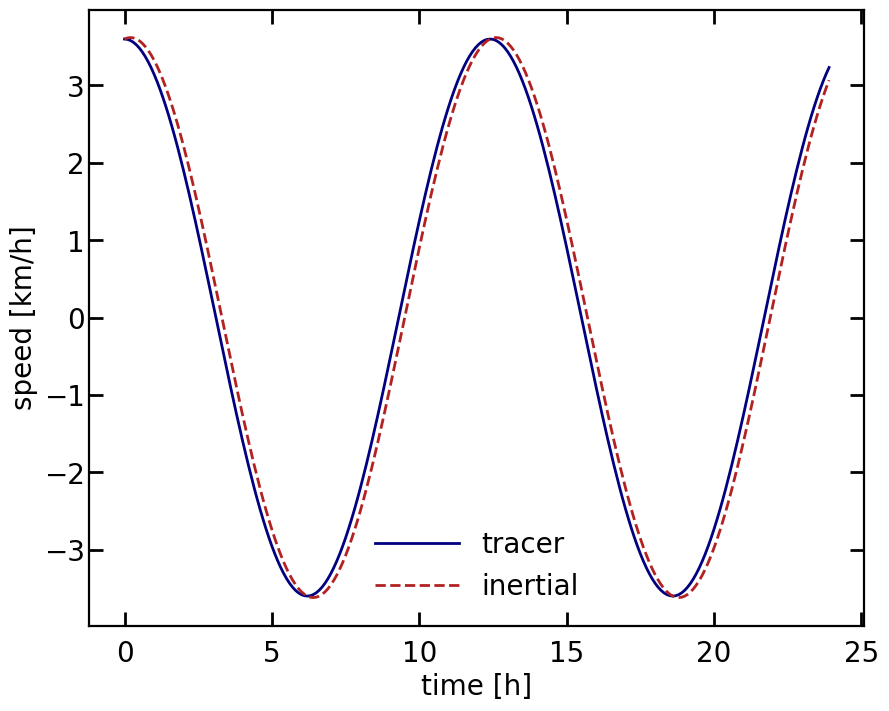

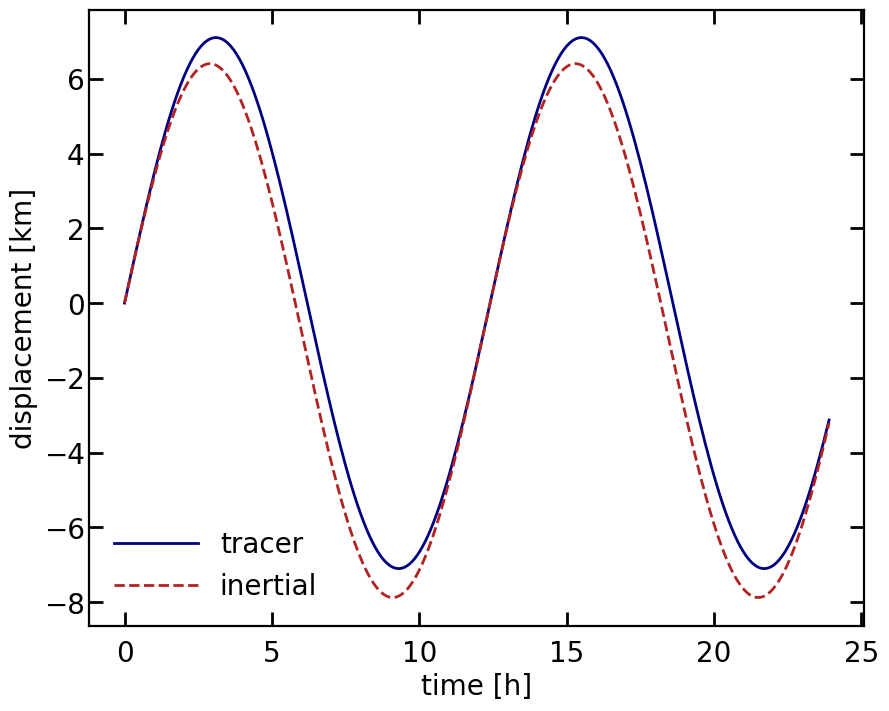

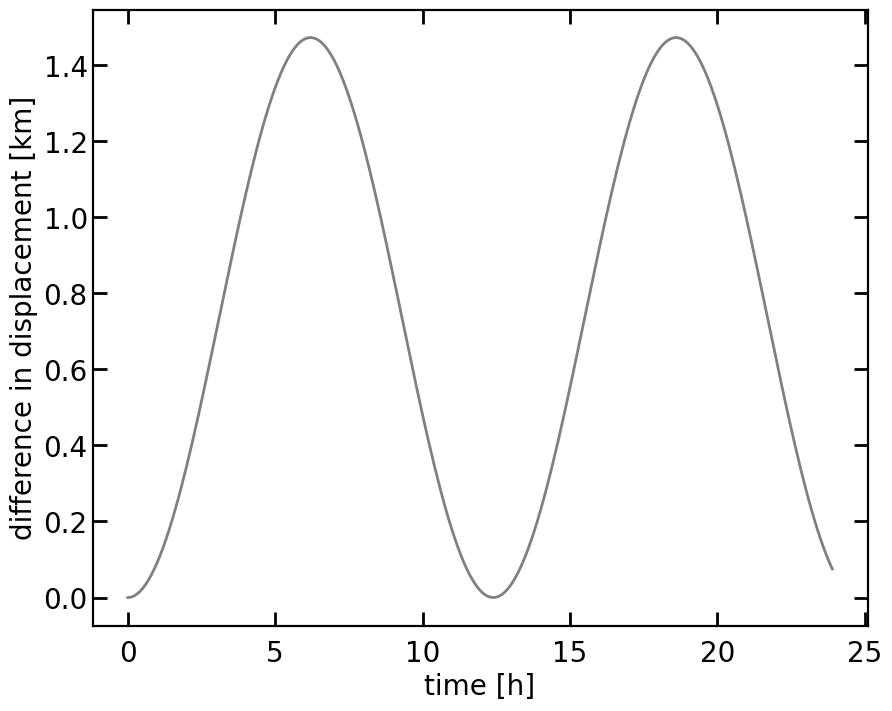

In [6]:
# theoretical tides plot
def Utide(A, f, t):
    return A * np.cos(f * t * 2 * np.pi)

def UMRtide(A,f,t,tau, B):
    factor = tau * 2 * (1 - B) / (2 * B + 1)
    return Utide(A, f, t) + factor * A * f * 2 * np.pi *  np.sin(f * t * 2 * np.pi)

def Xtidetracer(A, f, t):
    return A / (f * 2 * np.pi) * np.sin(f * t * 2 * np.pi)

def XtideMR(A,f,t, tau, B):
    factor = tau * 2 * (1 - B) / (2 * B + 1)  
    return Xtidetracer(A,f,t) + factor * Utide (A, f, t)


f = 1 / (12.4 ) # period is 12.4 h
A = 3.6 # km/h
tlist = np.arange(0,24,0.1)
fig,ax=plt.subplots()
ax.plot(tlist,Utide(A, f, tlist),color='navy')
ax.plot(tlist,UMRtide(A,f,tlist,tau/3600,B),'--',color='firebrick')
ax.set_xlabel('time [h]')
ax.set_ylabel('speed [km/h]')
ax.legend(['tracer','inertial'])

fig2,ax2=plt.subplots()
ax2.plot(tlist,Xtidetracer(A, f, tlist),color='navy')
ax2.plot(tlist,XtideMR(A,f,tlist,tau/3600,B) - XtideMR(A,f,0,tau/3600,B),'--',color='firebrick')
ax2.set_xlabel('time [h]')
ax2.set_ylabel('displacement [km]')
ax2.legend(['tracer','inertial'])

fig3,ax3=plt.subplots()
ax3.plot(tlist,Xtidetracer(A, f, tlist)-(XtideMR(A,f,tlist,tau/3600,B) - XtideMR(A,f,0,tau/3600,B)),color='grey')
ax3.set_xlabel('time [h]')
ax3.set_ylabel('difference in displacement [km]')